In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../scripts")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
plt.rcParams["figure.figsize"] = (14,6)

In [5]:
obs = pd.read_csv("../data/obs_arg.csv", parse_dates=["date"])
obs = obs.set_index("date")
obs = obs.drop(columns=["Total_Confirmed"])
obs

,I,R,D
date,,,
2020-03-03,1,0,0
2020-03-04,1,0,0
2020-03-05,1,0,0
2020-03-06,2,0,0
2020-03-07,8,0,0
...,...,...,...
2020-06-05,14317,6088,632
2020-06-06,15192,6180,648
2020-06-07,15221,6909,664


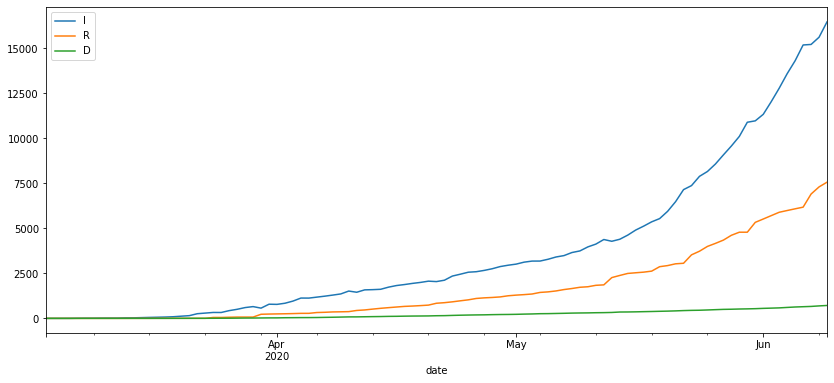

In [6]:
obs.plot()

In [7]:
obs = obs.rolling(window=7, min_periods=1).mean()

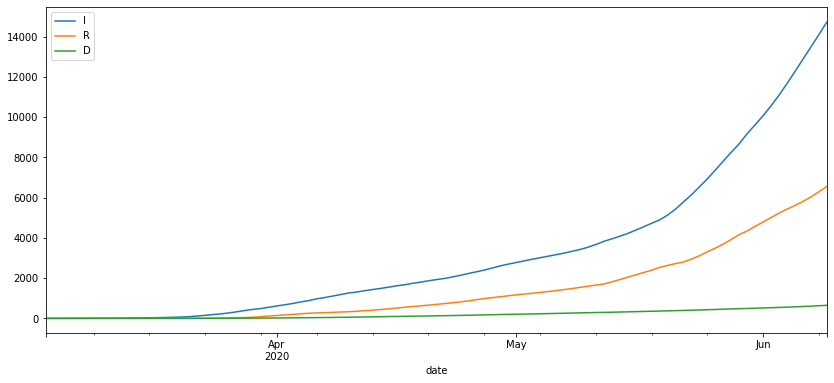

In [8]:
obs.plot()

In [9]:
def train_test_split(data, split, start=None, end=None):
    if start is None:
        start = data.index[0]
    if end is None:
        end = data.index[-1]
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    split = pd.to_datetime(split)
    one = pd.DateOffset(days=1)
    train = data[start:split-one].copy()
    test = data[split:end].copy()
    return train, test

In [10]:
data_start = "2020-04-01"
data_split = "2020-06-01"
train, test = train_test_split(obs, split=data_split, start=data_start)

In [11]:
train

,I,R,D
date,,,
2020-04-01,617.428571,142.142857,19.571429
2020-04-02,676.142857,169.714286,23.428571
2020-04-03,741.285714,197.428571,27.142857
2020-04-04,816.857143,227.000000,30.714286
2020-04-05,884.428571,256.714286,34.285714
...,...,...,...
2020-05-27,7818.571429,3695.857143,456.714286
2020-05-28,8260.571429,3922.285714,469.857143
2020-05-29,8683.000000,4168.857143,482.285714


In [12]:
test

,I,R,D
date,,,
2020-06-01,10080.142857,4795.142857,519.285714
2020-06-02,10575.000000,5015.428571,531.428571
2020-06-03,11104.285714,5236.428571,543.285714
2020-06-04,11678.428571,5433.000000,557.571429
2020-06-05,12279.285714,5618.714286,573.571429
2020-06-06,12892.714286,5817.571429,590.714286
2020-06-07,13499.142857,6042.285714,608.571429
2020-06-08,14111.142857,6297.142857,628.142857
2020-06-09,14744.714286,6562.714286,649.285714


## SIR

In [13]:
from SEIR import SIR

In [14]:
init_I, init_R, init_D = train.head(1).to_numpy().flatten()

In [15]:
model = SIR(population=44e6, init_infected=init_I, init_recovered=init_R, init_dead=init_D)

In [16]:
model.fit(train, estimate=('r_transmission', "r_recovery", "r_mortality"), 
          weights=None, method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[0.07090366, 0.02272984, 0.00309908],
       [0.07090317, 0.02272956, 0.00309893],
       [0.07090385, 0.02273001, 0.00309916],
       [0.07090343, 0.02272947, 0.00309924]]), array([35794.19340248, 35794.19344495, 35794.19344989, 35794.1934569 ]))
           fun: 35794.193402478115
       message: 'Optimization terminated successfully.'
          nfev: 234
           nit: 127
        status: 0
       success: True
             x: array([0.07090366, 0.02272984, 0.00309908])

In [17]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

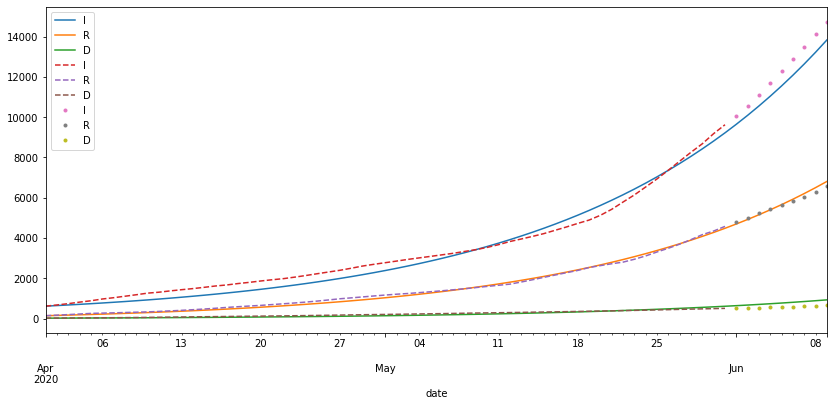

In [18]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")

## SEIR

In [19]:
from SEIR import SEIR

In [20]:
model = SEIR(population=44e6, init_infected=init_I, init_recovered=init_R, init_dead=init_D, init_exposed=1000)

In [21]:
model.fit(train, estimate=('r_transmission', "r_progression", "r_recovery", "r_mortality", "init_exposed"), 
          weights=None, method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[6.93509418e-02, 7.79579480e-01, 2.14062619e-02, 2.93045020e-03,
        1.94294918e+02],
       [6.93509416e-02, 7.79579346e-01, 2.14062604e-02, 2.93045199e-03,
        1.94294990e+02],
       [6.93509450e-02, 7.79579437e-01, 2.14062643e-02, 2.93045213e-03,
        1.94294936e+02],
       [6.93509513e-02, 7.79579631e-01, 2.14062650e-02, 2.93045448e-03,
        1.94294846e+02],
       [6.93509435e-02, 7.79579440e-01, 2.14062624e-02, 2.93045130e-03,
        1.94294921e+02],
       [6.93509437e-02, 7.79579380e-01, 2.14062620e-02, 2.93045179e-03,
        1.94294948e+02]]), array([27759.89610265, 27759.89610268, 27759.89610272, 27759.89610273,
       27759.89610274, 27759.89610276]))
           fun: 27759.89610264612
       message: 'Optimization terminated successfully.'
          nfev: 2916
           nit: 1841
        status: 0
       success: True
             x: array([6.93509418e-02, 7.79579480e-01, 2.14062619e-02, 2.93045020e-03,
       1.94294918e+02])

In [22]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

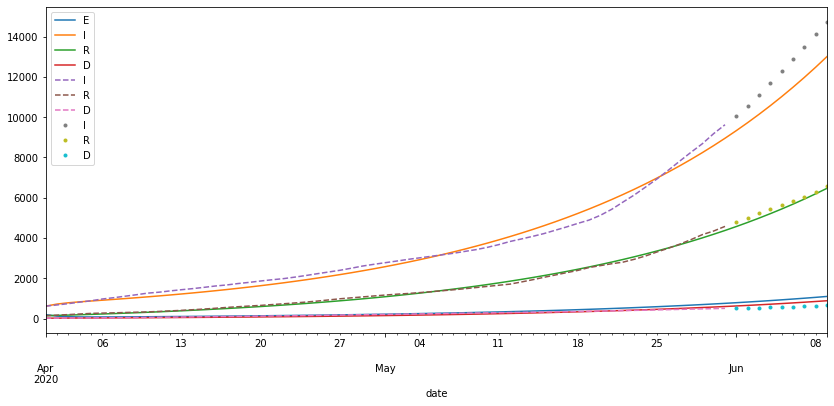

In [23]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")

## SEIRH

In [24]:
from SEIR import SEIRH

In [25]:
model = SEIRH(init_infected=init_I, init_recovered=init_R, init_dead=init_D, 
              init_exposed=1000, init_hospitalized=500,
              r_hospitalized=0.05, r_recovery_hosp=0.01, r_recovery_mild=0.1)

In [26]:
model.fit(train, estimate=('r_transmission', "r_progression", "r_mortality", 
                           "r_hospitalized", "r_recovery_hosp", "r_recovery_mild", 
                           "init_exposed", "init_hospitalized"), 
          weights=None, method="Nelder-Mead", options={"maxiter": 10000})

 final_simplex: (array([[ 8.65049183e-02,  2.09835325e-01,  8.57439114e-03,
         9.13765622e-03, -3.97770780e-04,  2.15911809e-02,
         4.06101224e+02,  6.10542867e+02],
       [ 8.65049191e-02,  2.09835324e-01,  8.57439094e-03,
         9.13765675e-03, -3.97770739e-04,  2.15911809e-02,
         4.06101222e+02,  6.10542877e+02],
       [ 8.65049189e-02,  2.09835323e-01,  8.57439066e-03,
         9.13765656e-03, -3.97770523e-04,  2.15911808e-02,
         4.06101222e+02,  6.10542901e+02],
       [ 8.65049198e-02,  2.09835321e-01,  8.57439018e-03,
         9.13765712e-03, -3.97770420e-04,  2.15911808e-02,
         4.06101224e+02,  6.10542938e+02],
       [ 8.65049173e-02,  2.09835329e-01,  8.57439141e-03,
         9.13765535e-03, -3.97771514e-04,  2.15911812e-02,
         4.06101213e+02,  6.10542864e+02],
       [ 8.65049175e-02,  2.09835325e-01,  8.57439214e-03,
         9.13765538e-03, -3.97771074e-04,  2.15911810e-02,
         4.06101217e+02,  6.10542817e+02],
       [ 8.650491

In [27]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=data_start, periods=T, freq="D")
res.index = idx

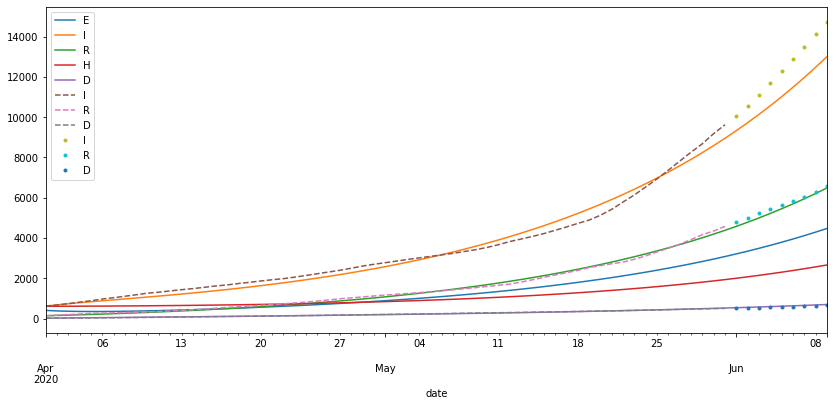

In [28]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")